## Let's try RNN

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import shutil
random.seed(0)
torch.manual_seed(0)


In [2]:
DATA_DIR = "./generated_data"
CSV_NAME = "mnst_2_lnstd_0.1.csv"

## Merge CSVs

In [3]:
# rename csv files
# for csv in os.listdir(DATA_DIR):
#     df = pd.read_csv(os.path.join(DATA_DIR,csv))
#     new_name = 'mnst_{}_lnstd_{}.csv'.format(df['motion noise stdev'][0],df['laser noise stdev'][0])
#     shutil.move(os.path.join(DATA_DIR,csv), os.path.join(DATA_DIR,new_name))
#     print(new_name)

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, CSV_NAME))

df = df.dropna(axis=1) # to prevent nan in model output
df.head()


,noisy motion,kalman prediction,ground truth,motion noise stdev,laser noise stdev,laser range 1,laser range 2,laser range 3,laser range 4,laser range 5,laser range 6
0,32.063360,5.014954,4.527978,2,0.1,4.998537,4.927686,4.919777,5.089352,4.958714,4.836348
1,32.108053,5.158915,4.574486,2,0.1,5.013025,4.986345,4.975599,4.671942,4.971018,4.949959
2,32.097932,5.319893,4.564363,2,0.1,5.034334,4.927298,5.154497,5.088942,4.825726,4.899361
3,32.377241,5.193629,4.765297,2,0.1,4.656789,4.656965,4.581776,4.857603,4.824811,4.783723
4,31.402264,5.363585,5.098723,2,0.1,4.565324,4.552719,4.370080,4.386198,4.455054,4.489313


In [5]:
df.columns

Index(['noisy motion', 'kalman prediction', 'ground truth',
       'motion noise stdev', 'laser noise stdev', 'laser range 1',
       'laser range 2', 'laser range 3', 'laser range 4', 'laser range 5',
       'laser range 6'],
      dtype='object')

In [9]:
df["laser noise stdev"].unique(), df["motion noise stdev"].unique()

(array([ 0.01, 10.  ,  1.  ,  0.1 ]), array([2, 4, 8]))

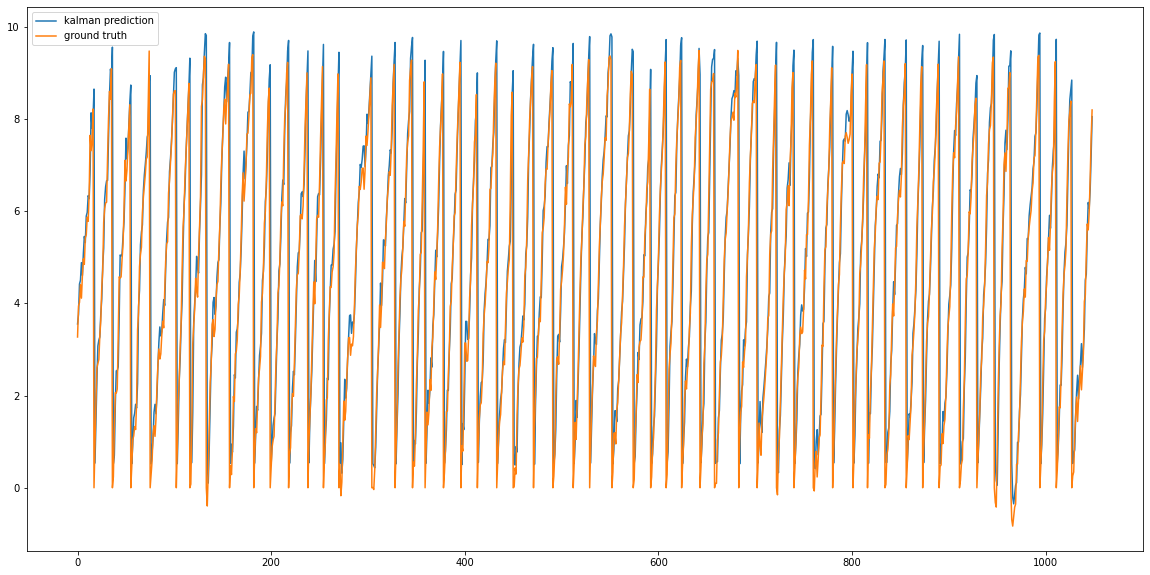

In [12]:
# Split
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)



# sanity checks

# kf_pred = torch.tensor(df['kalman prediction'].to_list()).reshape(-1, 1)
# gt = torch.tensor(df['ground truth'].to_list()).reshape(-1, 1)

split = -1


plt.figure(figsize=(20, 10))
plt.plot(df['kalman prediction'].to_list()[:split])
plt.plot(df['ground truth'].to_list()[:split])

plt.legend(['kalman prediction', 'ground truth'])




In [5]:
# df[df.isna().values]

## Model

In [6]:
# Define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    # def forward(self, x, h0):
    def forward(self, x):
        # h0 from the last batch

        # print(x.shape)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # print(h0.shape, torch.zeros(1, x.size(0), self.hidden_size).to(x.device).shape)
        out, _ = self.rnn(x, h0)
        if out.isnan().any():
            print("NAN:", out)
        fc_out = self.fc(out[:, -1, :]) # taking only the last hidden layer output
        # print(fc_out.shape, out.shape)
        if out.isnan().any():
            print("NAN: Second: ", out)
        return fc_out, out

## Reshape csv as per the seq length and batch size

In [7]:
def get_input_data(train_df, seq_len, batch_size, num_batches):

       labels = np.array(train_df["ground truth"].to_list())
       input_data_df = train_df[['noisy motion', 'motion noise stdev', 'laser noise stdev', 'laser range 1',
              'laser range 2', 'laser range 3', 'laser range 4', 'laser range 5',
              'laser range 6']].to_numpy()

       # input_data = input_data_df[:num_batches * batch_size]
       input_data = input_data_df.copy()

       # output_data = labels[:num_batches * batch_size]
       output_data = labels.copy()



       new_input_data = []
       new_output_data = []

       for i in range(len(input_data) - seq_len):
              new_input_data.append(input_data[i:i+seq_len])
              new_output_data.append(output_data[i + seq_len -1])

       new_input_data = np.array(new_input_data[:num_batches* batch_size]) # drop the last batch
       new_output_data = np.array(new_output_data[:num_batches* batch_size]) # drop the last batch
       
       return new_input_data, new_output_data


In [8]:
# new_input_data = []
# new_output_data = []

# for i in range(len(input_data) - seq_len):
#     new_input_data.append(input_data[i:i+seq_len])
#     new_output_data.append(output_data[i + seq_len -1])

# new_input_data = np.array(new_input_data[:num_batches* batch_size]) # drop the last batch
# new_output_data = np.array(new_output_data[:num_batches* batch_size]) # drop the last batch



In [9]:
# new_input_data.shape

In [10]:
# # sanity check
# print(new_input_data[0][-1], new_output_data[0].round(6))
# train_df.iloc[seq_len - 1]["ground truth"].round(6) == new_output_data[0].round(6)

# train_df.iloc[seq_len - 1]

In [52]:
seq_len = 100
batch_size = 10
num_batches = (len(train_df) - seq_len) // (batch_size)

new_input_data, new_output_data=  get_input_data(df, seq_len = seq_len, batch_size = batch_size, num_batches = num_batches)


new_input_data.shape == (num_batches* batch_size, seq_len, new_input_data.shape[-1])

True

In [53]:
# split
# train_input_data = new_input_data[:num_batches* batch_size//2]
# train_output_data = new_output_data[:num_batches* batch_size//2]
# new_input_data[:len(new_input_data)*0.8, ].shape

test_idx = random.sample(range(len(new_input_data)), k = int(len(new_input_data)*0.2))
train_idx = [i for i in range(len(new_input_data)) if i not in test_idx]

test_input = new_input_data[test_idx]
test_output = new_output_data[test_idx]

train_input = new_input_data[train_idx]
train_output = new_output_data[train_idx].reshape(-1, 1)


In [54]:
train_output.shape

(592, 1)

In [55]:
# train_input.shape, train_output.shape, test_input.shape, test_output.shape

# train_input.shape, batch_size, (train_input.shape[0]//batch_size)*batch_size
# 

# get pytorch csv dataloader
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_input).float(), torch.from_numpy(train_output).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_input).float(), torch.from_numpy(test_output).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False , drop_last=True)

## Gear Up | Train | Launch

In [63]:
input_size = 9
output_size = 1
hidden_size = 256
lr = 0.0001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleRNN(input_size, hidden_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
criterion_l1 = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.99)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 0.0001, 0.0001, 1000)


In [64]:
# Train the model
loss_cache = []


num_epochs = 100
for epoch in range(num_epochs):
    # hidden layer of the last batch
    # prev_batch_hidden = torch.zeros((1, batch_size, hidden_size)).to(device)

    # for i in range(len(train_input)):
    for inputs, targets in train_loader:
        # batch_inputs = train_input[i].to(device)
        # batch_outputs = train_target[i].to(device)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # print(batch_inputs.shape, batch_outputs.shape)
        # break

        optimizer.zero_grad()
        # output, hidden_output = model(inputs, prev_batch_hidden)
        output, hidden_output = model(inputs)
        # prev_batch_hidden = prev_batch_hidden
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        # lr_scheduler.step()

    loss_cache.append(loss.item())
    # Print the loss after every epoch
    if epoch %10 ==0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



Epoch [1/100], Loss: 11.7484
Epoch [11/100], Loss: 9.4287
Epoch [21/100], Loss: 7.3287
Epoch [31/100], Loss: 7.1284
Epoch [41/100], Loss: 7.2139
Epoch [51/100], Loss: 7.1228
Epoch [61/100], Loss: 7.0314
Epoch [71/100], Loss: 6.9586
Epoch [81/100], Loss: 6.8916
Epoch [91/100], Loss: 6.8267


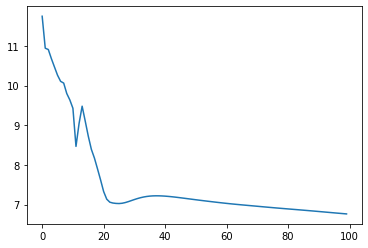

In [65]:
plt.plot(loss_cache)

## Pred

In [66]:
# test_input_df = test_df.drop(columns=["ground truth", "kalman prediction"])
# test_output_df = test_df["ground truth"]
# test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_input_df.to_numpy()).type(torch.float32), torch.from_numpy(test_output_df.to_numpy()).type(torch.float32))
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

loss_cache = []
test_pred = []
with torch.no_grad():
    for inputs, outputs in test_loader:
        inputs = inputs.to(device)
        outputs = outputs.to(device).view(-1, 1)
        # outputs = outputs
        pred, _ = model(inputs)
        test_pred.append(pred)
        loss = criterion(pred, outputs)
        # print(loss.item())
        loss_cache.append(loss.item())

In [67]:
sum(loss_cache)

46.65816888213158

In [68]:
# reshape test_pred to 1d
test_pred = torch.cat(test_pred, dim=0)

In [77]:
kl_test = df.iloc[test_idx]['kalman prediction']
kl_test.head()

695    7.099724
330    1.332818
510    8.732923
737    7.581360
650    4.708911
Name: kalman prediction, dtype: float64

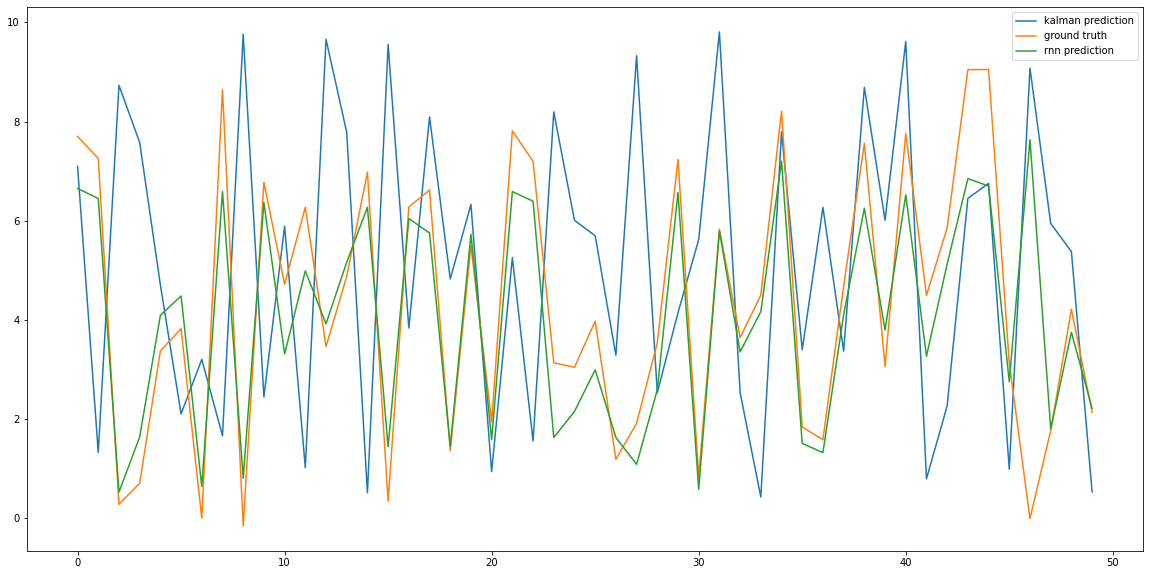

In [76]:
# kf_pred = torch.tensor(test_df['kalman prediction'].to_list()).reshape(-1, 1)
# gt = torch.tensor(test_df['ground truth'].to_list()).reshape(-1, 1)

# gt.shape, kf_pred.shape

split = 50


plt.figure(figsize=(20, 10))
plt.plot(kl_test[:split])
plt.plot(test_output[:split])
plt.plot(test_pred.detach().cpu()[:split])

plt.legend(['kalman prediction', 'ground truth', 'rnn prediction'])
# plt.legend(['ground truth', 'rnn prediction'])
# plt.plot(pred.to_list())


